In [1]:
###A Modern Geospatial Workflow in Python###

# What kind of python libraries make up a modern geospatial workflow? This is just a sample of what
# we consider to be the basic building blocks and what will be covered here:

#     shapely for geometric analysis
#     fiona for reading in vector formats
#     rasterio for reading in and working with raster formats
#     GeoPandas to extend pandas to work with geo formats
#     numpy and the python scientific computing stack for efficient computation
#     matplotlib for general plotting and visualization
#     folium for advanced and interactive plotting
#     scikit-learn for machine learning based data exploration, classification, and regression

import rasterio as rio
from rasterio.plot import show
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import fnmatch

In [2]:
# Note that the values here have been scaled between 0-1
src = rio.open("../Geopandas Practice - Rasters/landsat_studyarea.tif")
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 2813,
 'height': 2236,
 'count': 4,
 'crs': CRS.from_epsg(3098),
 'transform': Affine(30.0, 0.0, 547575.0,
        0.0, -30.0, 3667755.0)}

In [3]:
nir = src.read(4)
dataset = src.read()

# How about some band statistics?
band_mean = np.mean(nir)
band_min = np.min(nir)
band_max = np.max(nir)
band_stddev = np.std(nir)
print(f'Band range: {band_min} - {band_max}')
print(f'Band mean, stddev: {band_mean}, {band_stddev}')

Band range: 0.0 - 1.0
Band mean, stddev: 0.17326094210147858, 0.09751500189304352


In [18]:
show(nir);

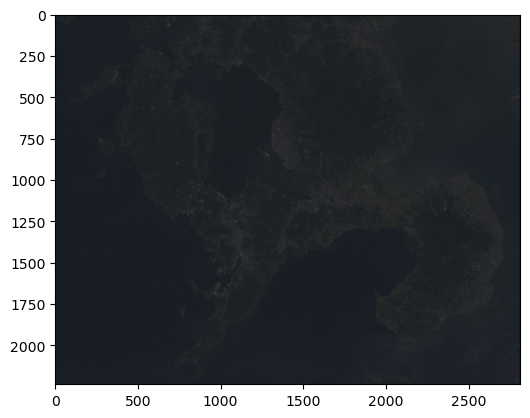

<Axes: >

In [23]:
# Can show the true color composite:
show(dataset[[2,1,0], :, :])

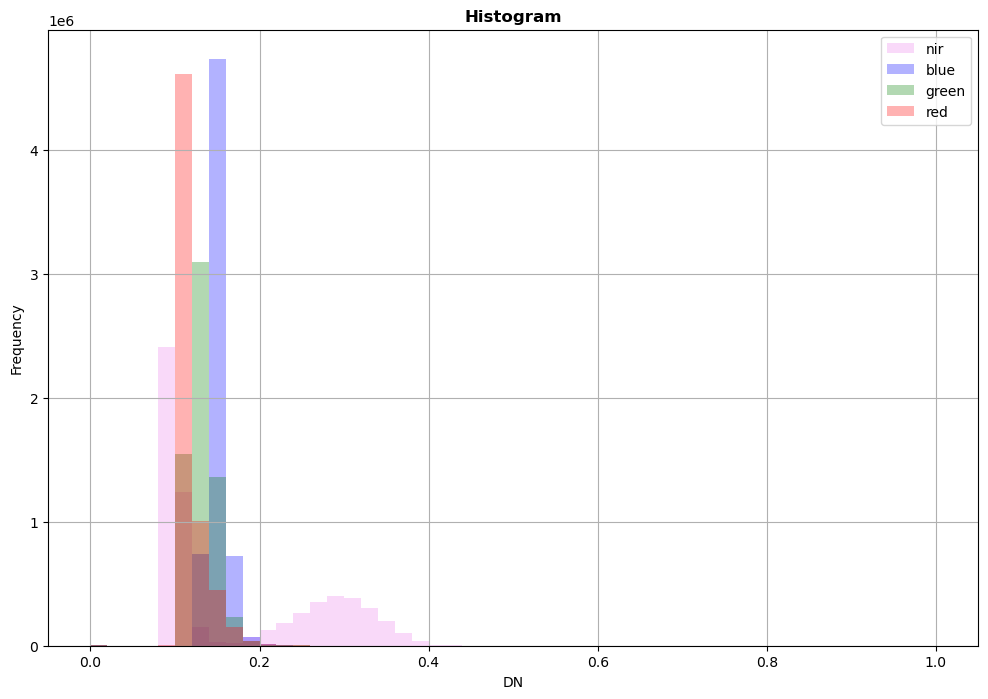

In [34]:
# We can use rio.plot.show_hist to create a histogram of the image
fig, ax = plt.subplots(figsize = (12,8))
# No good way to rearrange cmap - just read in the bands in the correct order instead
rio.plot.show_hist(dataset[[2,1,0,3], :, :], bins=50, histtype='stepfilled',
                   lw=0.0, stacked=False, alpha=0.3, 
                   label = ["red", "green", "blue", "nir"], ax = ax)
plt.set_cmap("Reds")

In [4]:
# Calculate NDVI
nir = src.read(4, masked = True)
red = src.read(3, masked = True)

r_ndvi = (nir - red) / (nir + red)

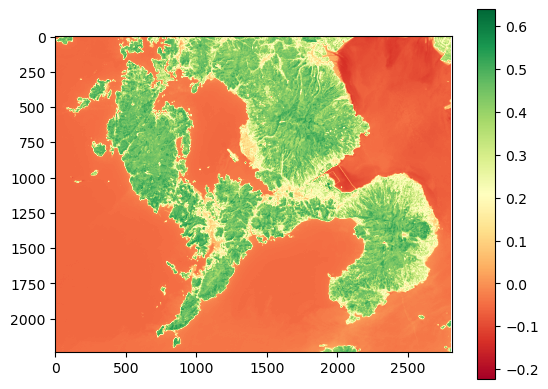

In [5]:
plt.imshow(r_ndvi, cmap = "RdYlGn")
plt.colorbar();

Text(0.5, 1.0, 'NIR vs. Red')

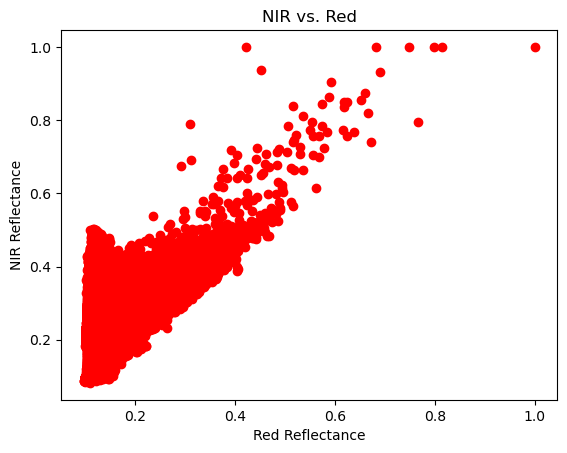

In [43]:
fig, ax = plt.subplots()

x = red.flatten()
y = nir.flatten()

# Note that this takes ridiculously long because we have nearly 4million points
plt.scatter(x, y, color = "r", marker = "o")
ax.set_xlabel("Red Reflectance")
ax.set_ylabel("NIR Reflectance")
ax.set_title("NIR vs. Red")

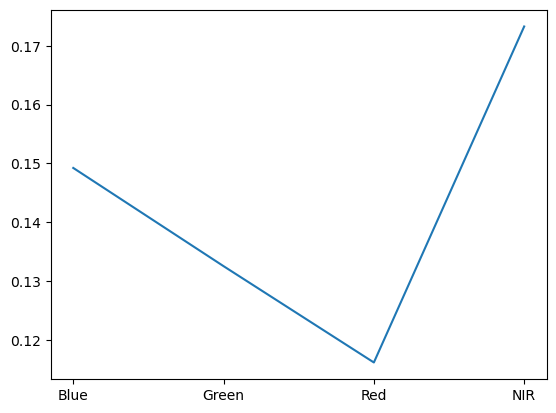

In [52]:
# Plot the relative intensity of each band:
y = np.mean(dataset, axis = (1,2))

# It is common to have this high reflectance in the NIR band (band 4 here)

fig, ax = plt.subplots()
plt.plot(np.arange(1, 5), y)
ax.set_xticks(ticks = np.arange(1, 5), labels = ["Blue", "Green", "Red", "NIR"])

In [55]:
fig, ax = plt.subplots()
img = ax.imshow(dataset[3, :, :], cmap = "viridis")
fig.colorbar(img, ax = ax);

In [67]:
# We can plot Red and NIR side by side
band_names = ["Blue", "Green", "Red", "NIR"]
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 20))

# Note that you must flatten the axs object, otherwise you will get an error:
# AttributeError: 'numpy.ndarray' object has no attribute 'imshow'
axs = axs.flatten()

# Reflectance in NIR is much higher
for band in range(4):
    img = axs[band].imshow(dataset[band, :, :], cmap = "viridis", vmin = 0, vmax = 1)
    fig.colorbar(img, ax = axs[band])
    axs[band].set_title(band_names[band])

In [13]:
# To create good looking images, imshow states that we need to normalize our bands into a 
# 0 - 1 range. To do so, we will perform a simple linear scale fitting 0 reflectance to 0 and 
# 80% reflectance to 1, clipping anything larger or smaller.

from rasterio.plot import reshape_as_raster, reshape_as_image

dataset = src.read(masked = True)

# Create a 3D numpy arrange with the NIR, Red, and Green bands
fcc_band_arrangement = np.array([3,2,1])
tcc_band_arrangement = np.array([2,1,0])
fcc = dataset[fcc_band_arrangement, :, :]
tcc = dataset[tcc_band_arrangement, :, :]

# Enforce 80th percentile of color in each band
# max_vals = np.percentile(dataset, 99, axis = (1,2)).reshape(4,1,1) # This returns the 80th percentile
max_vals = np.array([0.2,0.2,0.2,0.4]).reshape(4,1,1)
min_vals = np.zeros(4).reshape(4,1,1)
# min_vals = np.array([0.08,0.08,0.08,0]).reshape(4,1,1)

# Normalize the values to the range between 0 and 80th percentile
fcc_normed = fcc * 1 / (max_vals[fcc_band_arrangement, :, :] - min_vals[fcc_band_arrangement, :, :])
tcc_normed = tcc * 1 / (max_vals[tcc_band_arrangement, :, :] - min_vals[tcc_band_arrangement, :, :])

# Clip any values above 1 to 1.
fcc_normed[fcc_normed > 1] = 1
tcc_normed[tcc_normed > 1] = 1

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(fcc_normed.shape)
fcc_reshaped = reshape_as_image(fcc_normed)
print(fcc_reshaped.shape)
tcc_reshaped = reshape_as_image(tcc_normed)

(3, 2236, 2813)
(2236, 2813, 3)


Text(0.5, 1.0, 'NDVI')

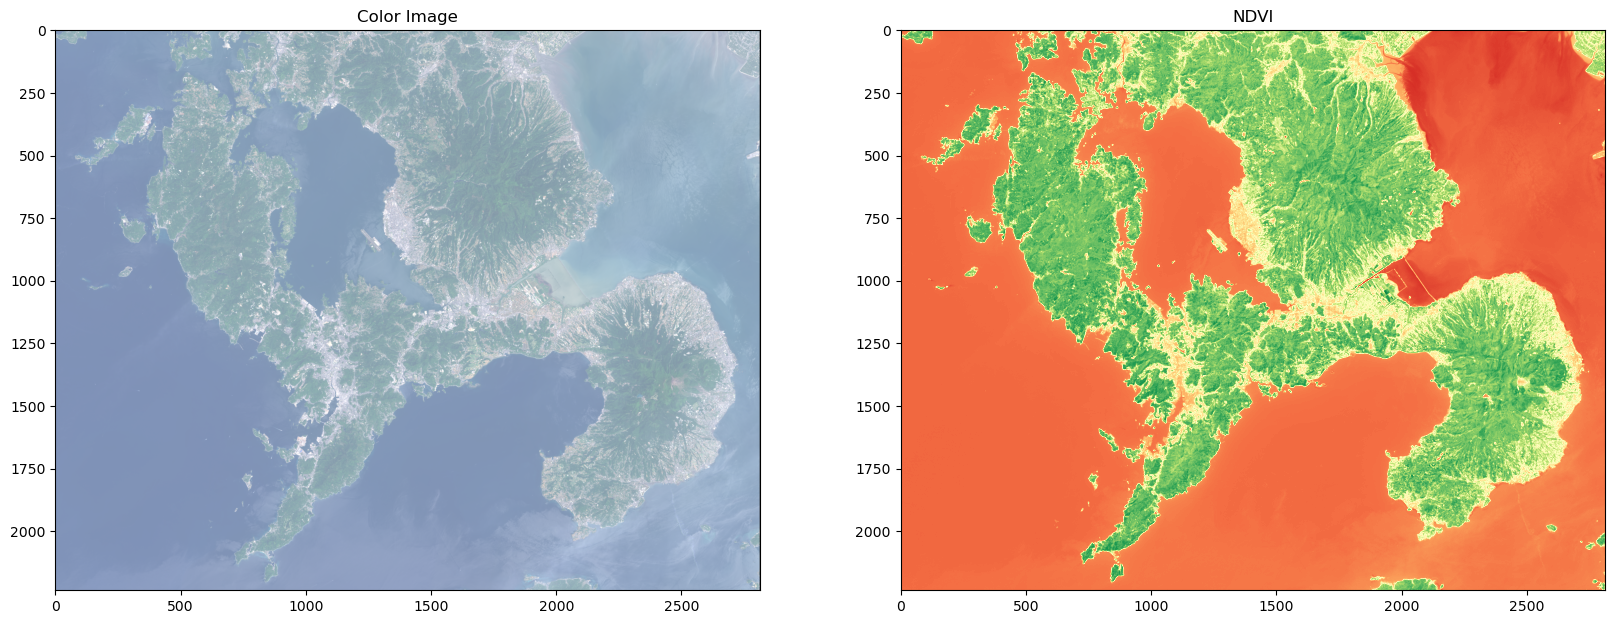

In [16]:
# Compare TCC to NDVI
fig, axs = plt.subplots(1, 2, figsize = (20,9))

# Show the color image
show(tcc_normed, ax = axs[0])
axs[0].set_title('Color Image')

# Show NDVI
show(r_ndvi, cmap='RdYlGn', ax = axs[1])
axs[1].set_title('NDVI')
# fig

In [13]:
rio.plot.show_hist(tcc_normed)

Text(0.5, 1.0, 'NDVI')

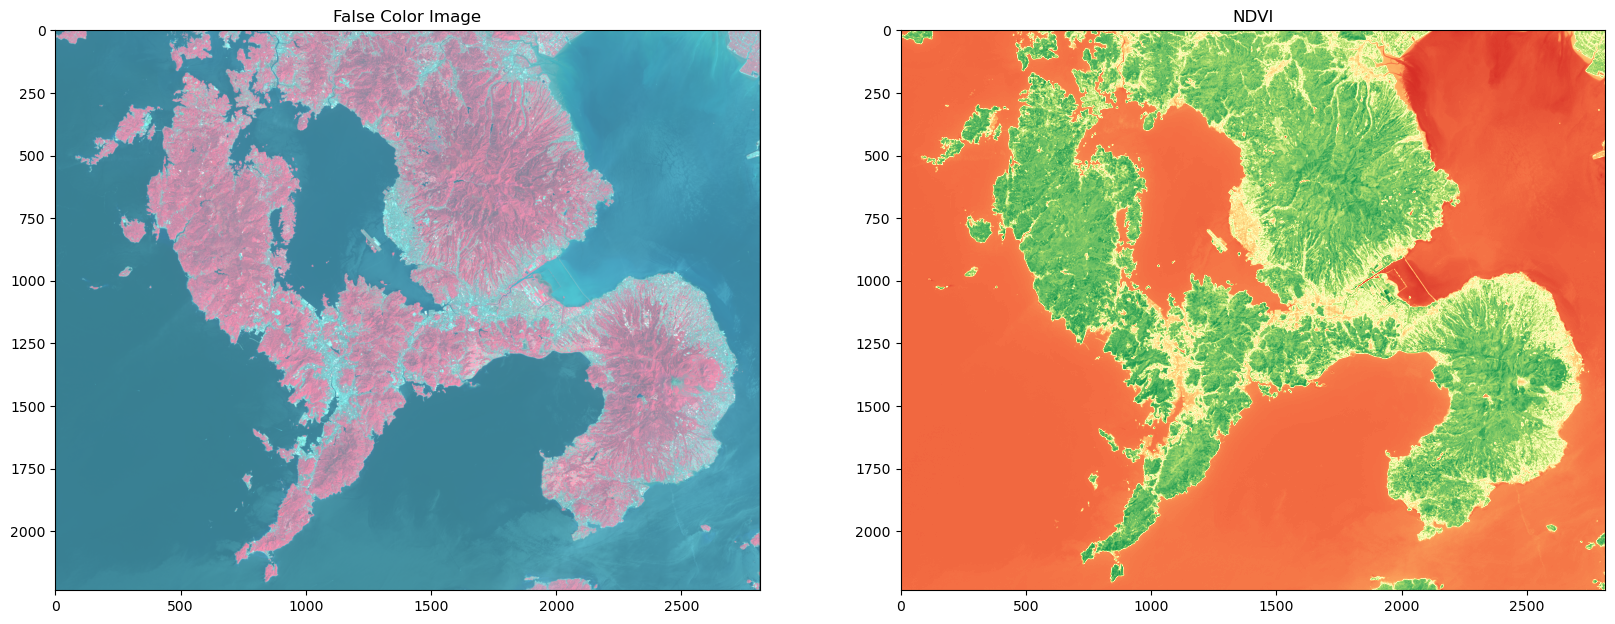

In [19]:
# Compare TCC to NDVI
fig, axs = plt.subplots(1, 2, figsize = (20,9))

# Show the color image
show(fcc_normed, ax = axs[0])
axs[0].set_title('False Color Image')

# Show NDVI
show(r_ndvi, cmap='RdYlGn', ax = axs[1])
axs[1].set_title('NDVI')
# fig

In [87]:
fcc

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [0.09385824203491211, 0.0940871313214302, 0.0940108373761177,
          ..., 0.26417943835258484, 0.24942396581172943, --],
         [0.09362936019897461, 0.09388875961303711, 0.09369039535522461,
          ..., 0.29147782921791077, 0.26121920347213745, --],
         ...,
         [0.0953078493475914, 0.095551997423172, 0.0961623564362526,
          ..., 0.110612653195858, 0.11296253651380539, --],
         [0.0959029495716095, 0.095613032579422, 0.0960860624909401,
          ..., 0.11567864567041397, 0.11581597477197647, --],
         [0.0959792509675026, 0.09674219787120819, 0.09643702208995819,
          ..., 0.12286564707756042, 0.11668574064970016, --]],

        [[--, --, --, ..., --, --, --],
         [0.10336461663246155, 0.10344091057777405, 0.10341039299964905,
          ..., 0.15262073278427124, 0.16629281640052795, --],
         [0.10334935784339905, 0.10331884026527405, 0.10359349846839905,
          ..., 0.150

In [73]:
# This returns the 80th percentile
np.max(dataset, axis = (1,2))

array([0.720119  , 0.81971467, 1.        , 1.        ], dtype=float32)